## 테스트 시나리오
1. 모듈 활용 배경 및 가명처리 대상 시나리오
- 에코마케팅 김모 마케터는 신한카드에서 고객 데이터를 사와서 마케팅 연구 용도로 사용하려고 한다.
- 이 과정에서 고객 데이터 중 유독 재식별 가능성이 높은 컬럼들을 골라서 가명처리를 하려고 한다.
- 가명처리 대상: DATA_FINANCE 중 INCOME_BRACKET(소득분위), CREDIT_SCORE(신용평점), AMT_CREDITCARD_PAYMENT(신용카드 결제액), AMT_CREDITLOAN(카드론 액수) 컬럼
- 가명처리 대상 2. DATA_RETAIL 중 AMT_PURCHASES_BOOKS, AMT_PURCHASES_CULTURE, AMT_PURCHASES_EDU
2. 모듈 적용 절차
- 테이블에서 분류 지표가 될만한 컬럼들을 가지고 동질집합을 만든뒤, 그 동질집합을 기반으로 가명처리 모듈, 프라이버시 보호모델 모듈을 적용시킨다
- 그 이후 성과지표가 어느 정도로 나오는지를 알아본다
- 가명처리된 결과물을 갖고
-> 결과물 데이터프레임을 DB에 넣은 뒤
-> 결합모듈로 결합을 수행한 뒤 결합된 데이터 + 결합못한 데이터를 합쳐 DB에 저장 (합칠때, 결합된건지 아닌건지 식별 해줘야함)

## 모듈 불러오기

In [1]:
import re

from prettytable import PrettyTable
import pandas as pd
pd.options.display.float_format = '{:.30f}'.format
import pprint

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys

In [2]:
sys.path.append("/Users/minjoo/codeStudy/psudonymizerTeam/pseudonymizer")
# sys.path.append("C:\Pseudonymizer\pseudonymizer")

## 가명처리

### 데이터 불러오기

In [3]:
from pseudonymizer.encryptionPseudonyms.pyMySQLQuery import *

In [4]:
queryObject = PyMySQLQuery(pw = "1234")
# queryObject = PyMySQLQuery(pw = "0123")

In [5]:
queryObject.connectDatabase(
    serverIP = "localhost", 
    port_num = 3306, 
    user_name = "root", 
    database_name = "FINANCIALCONSUMER", 
    kr_encoder = "utf8")
SQL = "SELECT * FROM DATA_FINANCE"
queryObject.dataQueryLanguage(sql = SQL)

In [6]:
DATA_FINANCE_TABLE = queryObject.executeQueryAsDataFrame()

In [7]:
queryObject2 = PyMySQLQuery(pw = "1234")
# queryObject2 = PyMySQLQuery(pw = "0123")

In [8]:
queryObject2.connectDatabase(
    serverIP = "localhost", 
    port_num = 3306, 
    user_name = "root", 
    database_name = "FINANCIALCONSUMER", 
    kr_encoder = "utf8")
SQL2 = "SELECT * FROM DATA_RETAIL"
queryObject2.dataQueryLanguage(sql = SQL2)

In [9]:
DATA_RETAIL_TABLE = queryObject2.executeQueryAsDataFrame()

In [10]:
DATA_FINANCE_TABLE.info()
DATA_FINANCE_TABLE.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95000 entries, 0 to 94999
Data columns (total 20 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   NUM_SERIAL                  95000 non-null  int64 
 1   NAME                        95000 non-null  object
 2   GENDER                      95000 non-null  object
 3   AGE                         95000 non-null  int64 
 4   PHONE_NUMBER                95000 non-null  object
 5   ZIP_CODE                    95000 non-null  int64 
 6   HOME_ADDRESS                95000 non-null  object
 7   HOME_TYPE                   95000 non-null  object
 8   INCOME_BRACKET              95000 non-null  int64 
 9   CREDIT_SCORE                95000 non-null  int64 
 10  REPAYMENT_RISK_INDEX        95000 non-null  int64 
 11  AMT_CREDITCARD_PAYMENT      95000 non-null  int64 
 12  AMT_CASHADVANCE_PAYMENT     95000 non-null  int64 
 13  NUM_CREDITCARD_ISSUANCES    95000 non-null  in

,NUM_SERIAL,NAME,GENDER,AGE,PHONE_NUMBER,ZIP_CODE,HOME_ADDRESS,HOME_TYPE,INCOME_BRACKET,CREDIT_SCORE,REPAYMENT_RISK_INDEX,AMT_CREDITCARD_PAYMENT,AMT_CASHADVANCE_PAYMENT,NUM_CREDITCARD_ISSUANCES,NUM_CREDITCARD_CANCELED,TF_LOAN,AMT_CREDITLOAN,AMT_CREDITLOAN_OUTSTANDING,TF_PENSION,AMT_PENSION
0,0,강현심,female,80,010-1826-4535,27218,충청북도 제천시 수산면 옥순봉로6길 61-32,"판잣집, 비닐하우스",6,441,61,5357418,8583708,3,5,N,0,0,N,0
1,1,서삼봉,female,30,010-1765-1467,12736,경기도 광주시 초월읍 도곡길 109-9,다세대주택,8,515,10,8870904,5328233,3,1,N,0,0,N,0
2,2,팽상아,female,53,010-6593-5091,51292,경상남도 창원시 마산회원구 회원남32길 28-1(회원동),"판잣집, 비닐하우스",1,269,17,8525658,2005663,6,5,N,0,0,N,0
3,3,박옥점,female,26,010-7714-1345,58541,전라남도 무안군 청계면 구로길 65,다가구 단독주택,7,254,10,2593007,8944424,4,1,N,0,0,N,0
4,4,윤경념,female,69,010-5360-6014,31741,충청남도 당진시 신평면 신평길 64-6,영업 겸용 단독주택,8,590,79,411525,5125357,5,3,N,0,0,N,0


In [11]:
DATA_RETAIL_TABLE.info()
DATA_RETAIL_TABLE.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85000 entries, 0 to 84999
Data columns (total 16 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   NUM_SERIAL                 85000 non-null  int64 
 1   NAME                       85000 non-null  object
 2   GENDER                     85000 non-null  object
 3   AGE                        85000 non-null  int64 
 4   JOIN_DATE                  85000 non-null  object
 5   PHONE_NUMBER               85000 non-null  object
 6   ZIP_CODE                   85000 non-null  int64 
 7   SHIPPING_ADDRESS           85000 non-null  object
 8   NUM_PURCHASES_BOOKS        85000 non-null  int64 
 9   AMT_PURCHASES_BOOKS        85000 non-null  int64 
 10  NUM_PURCHASES_CULTURE      85000 non-null  int64 
 11  AMT_PURCHASES_CULTURE      85000 non-null  int64 
 12  NUM_PURCHASES_EDU          85000 non-null  int64 
 13  AMT_PURCHASES_EDU          85000 non-null  int64 
 14  AMT_US

,NUM_SERIAL,NAME,GENDER,AGE,JOIN_DATE,PHONE_NUMBER,ZIP_CODE,SHIPPING_ADDRESS,NUM_PURCHASES_BOOKS,AMT_PURCHASES_BOOKS,NUM_PURCHASES_CULTURE,AMT_PURCHASES_CULTURE,NUM_PURCHASES_EDU,AMT_PURCHASES_EDU,AMT_USAGE_MEMBERSHIP,AMT_USAGE_GIFTCERTIFICATE
0,0,맹수원,male,73,2021-02-01,010-7161-5648,26310,강원특별자치도 원주시 소초면 대왕고개길 53-13,949,8588542,858,21911531,7768,1743329,1201564,1569165
1,1,가한성,male,44,2019-12-23,010-4411-3871,48235,부산광역시 수영구 연수로312번길 13(망미동),278,1696132,490,80849464,5430,5331234,1660142,967963
2,2,진노순,female,59,2020-04-15,010-8299-4394,63207,제주특별자치도 제주시 신성로13길 26(이도이동),324,3843932,706,79898363,5974,8858371,3106686,1829878
3,3,성간란,female,34,2020-02-12,010-8178-4332,42146,대구광역시 수성구 희망로36길 122-25(황금동),720,9124604,384,87698526,677,22899412,576470,2423582
4,4,프주희,female,49,2020-01-22,010-9654-3329,32932,충청남도 논산시 강경읍 금백로175번길 23,9,1412817,20,22057893,332,27086237,978040,901883


### DATA_FINANCE 가명처리
- 가명처리 대상: DATA_FINANCE 중 INCOME_BRACKET(소득분위), CREDIT_SCORE(신용평점), AMT_CREDITCARD_PAYMENT(신용카드 결제액), AMT_CREDITLOAN(카드론 액수) 컬럼
- 가명처리 방법
    - NAME : MaskingPseudonymizer(data_type="name")
    - HOME_ADDRESS : MaskingPseudonymizer(data_type="")
    - EMAIL : MaskingPseudonymizer(data_type="email")
    - PHONE_NUMBER : MaskingPseudonymizer(data_type="phone_number")
    - INCOME_BRACKET
        - CategorizationOfNumeric("user_definition", category_mapping={"1~3분위": (1, 3), "4분위": (4, 4), "5분위": (5, 5), "6분위": (6, 6), "7분위": (7, 7), "8~10분위": (8, 10)})
    - CREDIT_SCORE : 
        - 수동: CategorizationOfNumeric("user_definition", category_mapping={"저신용평점": (0, 600), "중신용평점": (600, 900), "고신용평점": (900, 1000)})
        - 자동 : CategorizationOfColumn("bin", grouping_standard=["저신용평점", "중신용평점", "고신용평점"], right=True, ascending=True)
    - REPAYMENT_RISK_INDEX :
        - CategorizationOfColumn("pct", grouping_standard=5, right=False, ascending=True)
    - AMT_CREDITCARD_PAYMENT :
        - TopandBottomCoding(outlier_type="Pct")
        - KLT 적용 이후 MicroAggregation() 적용
        - RandomRoundingPseudonymizer(rounding_type="custom_round")
    - AMT_CREDITLOAN (신용대출) : 
        - TopandBottomCoding(outlier_type="IQR")
        - KLT 적용 이후 MicroAggregation() 적용
- 동질집합: [TF_LOAN, TF_PENSION, NUM_CREDITCARD_ISSUANCES]

In [7]:
from pseudonymizer.pseudonym import Pseudonym
from pseudonymizer.pseudonymizers.numcategorization import CategorizationOfNumeric
from pseudonymizer.pseudonymizers.topandBottomCoding import TopandBottomCoding
from pseudonymizer.pseudonymizers.columncategorization import CategorizationOfColumn
from pseudonymizer.pseudonymizers.microAggregation import MicroAggregation
from pseudonymizer.pseudonymizers.maskingPseudonymizer import MaskingPseudonymizer

In [8]:
from pseudonymizer.privacyPreservingModels import PrivacyPreservingModel

In [14]:
# 테스트
"""
address_masker = AddressMaskingModule("시군구")
masked_address = address_masker.pseudonymizeData("서울특별시 강남구 역삼동")
print("마스킹된 주소:", masked_address)
"""

'\naddress_masker = AddressMaskingModule("시군구")\nmasked_address = address_masker.pseudonymizeData("서울특별시 강남구 역삼동")\nprint("마스킹된 주소:", masked_address)\n'

In [9]:
# COMPLETE
name_pseudo = MaskingPseudonymizer(data_type="name")

In [10]:
home_address_pseudo = MaskingPseudonymizer(data_type="address") # 현재 주소는 주소로 인식 안됨
phone_pseudo = MaskingPseudonymizer(data_type="phone_number") # COMPLETE

In [11]:
# COMPLETE
income_pseudo = CategorizationOfNumeric(numeric_type="user_definition", 
                                        category_mapping={"1~3분위": (1, 3), "4분위": (4, 4), "5분위": (5, 5), 
                                                          "6분위": (6, 6), "7분위": (7, 7), "8~10분위": (8, 10)})
# COMPLETE
credit_pseudo_user = CategorizationOfNumeric(numeric_type="user_definition",
                                             category_mapping={"저신용평점": (0, 600), "중신용평점": (600, 900), "고신용평점": (900, 1000)})
# TypeError: can only concatenate str (not "float") to str
credit_pseudo_auto = CategorizationOfColumn(numeric_type="bin", grouping_standard=["저신용평점", "중신용평점", "고신용평점"], 
                                            right=True, ascending=True)
# COMPLETE
repayment_risk_pseudo = CategorizationOfColumn(numeric_type="pct", grouping_standard=5, right=False, ascending=True)

In [9]:
# ERROR
card_pay_pseudo = TopandBottomCoding(outlier_type="Pct", bounded_value=0.1)
credit_loan_pseudo = TopandBottomCoding(outlier_type="IQR", bounded_value=0.1)
# ppm = PrivacyPreservingModel(dataframe=DATA_FINANCE_TABLE, epsilon = )

In [91]:
micro_credit = MicroAggregation(calulate_type="max", 
                                quasi_identifier=("N", "Y", 9))

---

In [10]:
pseudonymizer = Pseudonym(dataframe=DATA_FINANCE_TABLE)

In [11]:
pseudonymizer.categorizeEquivalentClass(["TF_LOAN", "TF_PENSION", "NUM_CREDITCARD_ISSUANCES"])

In [94]:
# COMPLETE
pseudonymizer.addDictionary(column="NAME", pseudonymizers=[name_pseudo])

In [95]:
# pseudonymizer.addDictionary(column="HOME_ADDRESS", pseudonymizers=[home_address_pseudo])
pseudonymizer.addDictionary(column="PHONE_NUMBER", pseudonymizers=[phone_pseudo])

In [96]:
# COMPLETE
# pseudonymizer.addDictionary(column="INCOME_BRACKET", pseudonymizers=[income_pseudo]) # O
# pseudonymizer.addDictionary(column="CREDIT_SCORE", pseudonymizers=[credit_pseudo_user]) # O # credit_pseudo_auto
pseudonymizer.addDictionary(column="REPAYMENT_RISK_INDEX", pseudonymizers=[repayment_risk_pseudo]) # ERROR -> O

In [97]:
pseudonymizer.addDictionary(column="CREDIT_SCORE", pseudonymizers=[credit_pseudo_auto])

In [98]:
pseudonymizer.addDictionary(column="AMT_CREDITCARD_PAYMENT", pseudonymizers=[card_pay_pseudo]) # ERROR
    # 데이터프레임의 열에 있는 값이 서로 다른 타입일 때 발생
    # if lower <= numeric_tobeclassified <= upper:
    #         return category
    # return "other types"
    # TypeError: '<=' not supported between instances of 'int' and 'str'

In [12]:
pseudonymizer.addDictionary(column="AMT_CREDITLOAN", pseudonymizers=[credit_loan_pseudo]) # ERROR

In [100]:
pseudonymizer.addDictionary(column="AMT_CREDITLOAN", pseudonymizers=[micro_credit])

---

In [13]:
pseudonymizer._pseudonymDictionary

{'AMT_CREDITLOAN': [<pseudonymizer.pseudonymizers.topandBottomCoding.TopandBottomCoding at 0x14d5659d0>]}

In [14]:
tbc = TopandBottomCoding(outlier_type="IQR", bounded_value=0.1)
tbc.pseudonymizeData(dataseries=DATA_FINANCE_TABLE["AMT_CREDITLOAN"])

AttributeError: 'list' object has no attribute 'to_list'

In [109]:
pseudonymizer.pseudonymizeData()

AttributeError: 'list' object has no attribute 'to_list'

In [103]:
result = pseudonymizer.getPseudonymizedDataframe()

In [80]:
result["AMT_CREDITLOAN"][73840]

0

In [104]:
result

,NUM_SERIAL,NAME,GENDER,AGE,PHONE_NUMBER,ZIP_CODE,HOME_ADDRESS,HOME_TYPE,INCOME_BRACKET,CREDIT_SCORE,REPAYMENT_RISK_INDEX,AMT_CREDITCARD_PAYMENT,AMT_CASHADVANCE_PAYMENT,NUM_CREDITCARD_ISSUANCES,NUM_CREDITCARD_CANCELED,TF_LOAN,AMT_CREDITLOAN,AMT_CREDITLOAN_OUTSTANDING,TF_PENSION,AMT_PENSION
0,0,강**,female,80,010-1826-****,27218,충청북도 제천시 수산면 옥순봉로6길 61-32,"판잣집, 비닐하우스",6,중신용평점,60 이상,4576964,8583708,3,5,N,0,0,N,0
1,1,서**,female,30,010-1765-****,12736,경기도 광주시 초월읍 도곡길 109-9,다세대주택,8,중신용평점,5 이상,4576964,5328233,3,1,N,0,0,N,0
2,2,팽**,female,53,010-6593-****,51292,경상남도 창원시 마산회원구 회원남32길 28-1(회원동),"판잣집, 비닐하우스",1,저신용평점,15 이상,4576964,2005663,6,5,N,0,0,N,0
3,3,박**,female,26,010-7714-****,58541,전라남도 무안군 청계면 구로길 65,다가구 단독주택,7,저신용평점,5 이상,2593007,8944424,4,1,N,0,0,N,0
4,4,윤**,female,69,010-5360-****,31741,충청남도 당진시 신평면 신평길 64-6,영업 겸용 단독주택,8,중신용평점,75 이상,594537,5125357,5,3,N,0,0,N,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94995,94995,갈**,female,79,010-9796-****,36447,경상북도 영덕군 달산면 청련길 10-10,다세대주택,8,고신용평점,55 이상,835585,6144642,5,1,N,0,0,Y,0
94996,94996,림**,male,53,010-2817-****,26200,강원특별자치도 영월군 무릉도원면 황정길 253-11,기타,7,고신용평점,80 이상,4576964,6000005,5,3,N,0,0,N,0
94997,94997,명**,female,66,010-2536-****,14614,경기도 부천시 장말로 292(심곡동),연립주택,4,저신용평점,25 이상,4576964,7377056,8,2,N,0,0,N,0
94998,94998,롤**,female,73,010-5091-****,32755,충청남도 금산군 부리면 물페기길 66,오피스텔,6,고신용평점,5 이상,4576964,3625570,3,2,N,0,0,N,0


In [ ]:
pseudonymizer.pseudonymizeData()

In [17]:
# plt.hist(DATA_FINANCE_TABLE["AMT_CREDITCARD_PAYMENT"], color = "blue", alpha = 0.3)
# plt.hist(pseudonymizer._dataframe["AMT_CREDITCARD_PAYMENT"], color = "yellow", alpha = 0.3)
np.sort(pseudonymizer._dataframe["AMT_CREDITCARD_PAYMENT"]), np.sort(DATA_FINANCE_TABLE["AMT_CREDITCARD_PAYMENT"])

(array([ 594537,  594537,  594537, ..., 4576964, 4576964, 4576964]),
 array([ 100018,  100044,  100117, ..., 9999385, 9999796, 9999798]))

In [18]:
# plt.hist(DATA_FINANCE_TABLE["AMT_CREDITLOAN"], color = "blue", alpha = 0.5)
# plt.hist(pseudonymizer._dataframe["AMT_CREDITLOAN"], color = "yellow", alpha = 0.3)
np.sort(pseudonymizer._dataframe["AMT_CREDITLOAN"]), np.sort(DATA_FINANCE_TABLE["AMT_CREDITLOAN"])

(array([       0,        0,        0, ..., 49980338, 49994954, 49999255]),
 array([       0,        0,        0, ..., 49980338, 49994954, 49999255]))

- MaskingPseudonymizer name, address, phone number 전부 수정 필요

In [82]:
pseudonymizer._dataframe

,NUM_SERIAL,NAME,GENDER,AGE,PHONE_NUMBER,ZIP_CODE,HOME_ADDRESS,HOME_TYPE,INCOME_BRACKET,CREDIT_SCORE,REPAYMENT_RISK_INDEX,AMT_CREDITCARD_PAYMENT,AMT_CASHADVANCE_PAYMENT,NUM_CREDITCARD_ISSUANCES,NUM_CREDITCARD_CANCELED,TF_LOAN,AMT_CREDITLOAN,AMT_CREDITLOAN_OUTSTANDING,TF_PENSION,AMT_PENSION
0,0,강현심,female,80,010-1826-4535,27218,충청북도 제천시 수산면 옥순봉로6길 61-32,"판잣집, 비닐하우스",6,441,61,5357418,8583708,3,5,N,0,0,N,0
1,1,서삼봉,female,30,010-1765-1467,12736,경기도 광주시 초월읍 도곡길 109-9,다세대주택,8,515,10,8870904,5328233,3,1,N,0,0,N,0
2,2,팽상아,female,53,010-6593-5091,51292,경상남도 창원시 마산회원구 회원남32길 28-1(회원동),"판잣집, 비닐하우스",1,269,17,8525658,2005663,6,5,N,0,0,N,0
3,3,박옥점,female,26,010-7714-1345,58541,전라남도 무안군 청계면 구로길 65,다가구 단독주택,7,254,10,2593007,8944424,4,1,N,0,0,N,0
4,4,윤경념,female,69,010-5360-6014,31741,충청남도 당진시 신평면 신평길 64-6,영업 겸용 단독주택,8,590,79,411525,5125357,5,3,N,0,0,N,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94995,94995,갈재희,female,79,010-9796-1142,36447,경상북도 영덕군 달산면 청련길 10-10,다세대주택,8,868,58,835585,6144642,5,1,N,0,0,Y,0
94996,94996,림상영,male,53,010-2817-1504,26200,강원특별자치도 영월군 무릉도원면 황정길 253-11,기타,7,875,83,4691445,6000005,5,3,N,0,0,N,0
94997,94997,명시라,female,66,010-2536-2511,14614,경기도 부천시 장말로 292(심곡동),연립주택,4,294,26,8488084,7377056,8,2,N,0,0,N,0
94998,94998,롤미라,female,73,010-5091-5053,32755,충청남도 금산군 부리면 물페기길 66,오피스텔,6,986,7,5109440,3625570,3,2,N,0,0,N,0


### DATA_RETAIL 가명처리
- AMT_PURCHASES_BOOKS, AMT_PURCHASES_CULTURE, AMT_PURCHASES_EDU
- 차분프라이버시 적용 (라플라스 or 가우시안 하나씩 해보기)
- AMT_PURCHASES_BOOKS -> 가우시안, 나머지 라플라스
- 동질집합: ["AGE", "GENDER"]
- 개인정보 마스킹: NAME, PHONE_NUMBER, ZIP_CODE, SHIPPING_ADDRESS
- JOIN_DATE (날짜 컬럼) -> CategorizationOfNumeric(numeric_type="age", grouping_standard="3bin")

In [22]:
DATA_RETAIL_TABLE.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85000 entries, 0 to 84999
Data columns (total 16 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   NUM_SERIAL                 85000 non-null  int64 
 1   NAME                       85000 non-null  object
 2   GENDER                     85000 non-null  object
 3   AGE                        85000 non-null  int64 
 4   JOIN_DATE                  85000 non-null  object
 5   PHONE_NUMBER               85000 non-null  object
 6   ZIP_CODE                   85000 non-null  int64 
 7   SHIPPING_ADDRESS           85000 non-null  object
 8   NUM_PURCHASES_BOOKS        85000 non-null  int64 
 9   AMT_PURCHASES_BOOKS        85000 non-null  int64 
 10  NUM_PURCHASES_CULTURE      85000 non-null  int64 
 11  AMT_PURCHASES_CULTURE      85000 non-null  int64 
 12  NUM_PURCHASES_EDU          85000 non-null  int64 
 13  AMT_PURCHASES_EDU          85000 non-null  int64 
 14  AMT_US

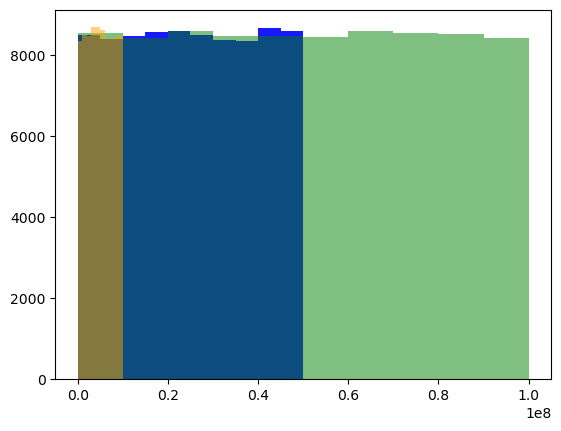

In [23]:
plt.hist(DATA_RETAIL_TABLE["AMT_PURCHASES_EDU"], color = "blue", alpha = 0.9)
plt.hist(DATA_RETAIL_TABLE["AMT_PURCHASES_CULTURE"], color = "green", alpha = 0.5)
plt.hist(DATA_RETAIL_TABLE["AMT_PURCHASES_BOOKS"], color = "orange", alpha = 0.5)
plt.show()

## 프라이버시 보호모델 테스트

In [11]:
from pseudonymizer.privacyPreservingModels import PrivacyPreservingModel

In [12]:
books_pseudo = PrivacyPreservingModel(dataframe=DATA_FINANCE_TABLE, epsilon=1)
# books_pseudo.applyDPrivacy(method="Laplace", boundary = 2,
#                                     attributes = ["HOME_TYPE", "TF_LOAN", "TF_PENSION"], 
#                                     sensitive_attribute = "AMT_CREDITLOAN",
#                                     outlier="lower")
books_pseudo.applyKAnonymityOrLDiversity(method="L", K = 1, L = 2, attributes = ["HOME_TYPE", "TF_LOAN", "TF_PENSION"],
                                         sensitive_attribute = "AMT_CREDITLOAN")

('기타', 'N', 'N') 1
('기타', 'N', 'Y') 1
('다가구 단독주택', 'N', 'N') 1
('다가구 단독주택', 'N', 'Y') 1
('다세대주택', 'N', 'N') 1
('다세대주택', 'N', 'Y') 1
('비거주용 건물(상가', 'N', 'N') 1
('비거주용 건물(상가', 'N', 'Y') 1
('아파트', 'N', 'N') 1
('아파트', 'N', 'Y') 1
('연립주택', 'N', 'N') 1
('연립주택', 'N', 'Y') 1
('영업 겸용 단독주택', 'N', 'N') 1
('영업 겸용 단독주택', 'N', 'Y') 1
('오피스텔', 'N', 'N') 1
('오피스텔', 'N', 'Y') 1
('일반 단독주택', 'N', 'N') 1
('일반 단독주택', 'N', 'Y') 1
('판잣집, 비닐하우스', 'N', 'N') 1
('판잣집, 비닐하우스', 'N', 'Y') 1


{('기타', 'Y', 'N'): [338,
  353,
  740,
  1858,
  2460,
  3193,
  3228,
  3268,
  3330,
  3441,
  3560,
  3583,
  3650,
  3979,
  4501,
  4508,
  4588,
  4688,
  4743,
  4865,
  5037,
  5070,
  5273,
  5447,
  5548,
  5847,
  6019,
  6647,
  6774,
  7009,
  7049,
  7247,
  7319,
  7358,
  7679,
  7761,
  8020,
  8164,
  8176,
  8202,
  8320,
  8409,
  8510,
  8514,
  8795,
  8797,
  8875,
  9058,
  9063,
  9098,
  9341,
  9598,
  9739,
  9879,
  10153,
  10804,
  11167,
  11556,
  11595,
  11714,
  11970,
  12232,
  12289,
  12298,
  12496,
  12540,
  12853,
  12937,
  13455,
  13568,
  13709,
  13975,
  14521,
  14552,
  14744,
  14771,
  15098,
  15099,
  15135,
  15173,
  15416,
  15455,
  15699,
  15900,
  15977,
  16047,
  16145,
  16332,
  16376,
  17134,
  17302,
  17332,
  17845,
  18079,
  18197,
  18382,
  18591,
  18880,
  19776,
  20201,
  20477,
  20580,
  20750,
  20863,
  20924,
  21203,
  21395,
  21629,
  21838,
  22112,
  22159,
  22446,
  23075,
  23323,
  23399,
  24

In [13]:
books_pseudo.applyLocalLDiversity(K = 1, L = 2, attributes = ["HOME_TYPE", "TF_LOAN", "TF_PENSION"],
                                         sensitive_attribute = "AMT_CREDITLOAN", LocalL=1)

('기타', 'N', 'N') 1
('기타', 'N', 'Y') 1
('다가구 단독주택', 'N', 'N') 1
('다가구 단독주택', 'N', 'Y') 1
('다세대주택', 'N', 'N') 1
('다세대주택', 'N', 'Y') 1
('비거주용 건물(상가', 'N', 'N') 1
('비거주용 건물(상가', 'N', 'Y') 1
('아파트', 'N', 'N') 1
('아파트', 'N', 'Y') 1
('연립주택', 'N', 'N') 1
('연립주택', 'N', 'Y') 1
('영업 겸용 단독주택', 'N', 'N') 1
('영업 겸용 단독주택', 'N', 'Y') 1
('오피스텔', 'N', 'N') 1
('오피스텔', 'N', 'Y') 1
('일반 단독주택', 'N', 'N') 1
('일반 단독주택', 'N', 'Y') 1
('판잣집, 비닐하우스', 'N', 'N') 1
('판잣집, 비닐하우스', 'N', 'Y') 1


{('기타', 'Y', 'N'): [338,
  353,
  740,
  1858,
  2460,
  3193,
  3228,
  3268,
  3330,
  3441,
  3560,
  3583,
  3650,
  3979,
  4501,
  4508,
  4588,
  4688,
  4743,
  4865,
  5037,
  5070,
  5273,
  5447,
  5548,
  5847,
  6019,
  6647,
  6774,
  7009,
  7049,
  7247,
  7319,
  7358,
  7679,
  7761,
  8020,
  8164,
  8176,
  8202,
  8320,
  8409,
  8510,
  8514,
  8795,
  8797,
  8875,
  9058,
  9063,
  9098,
  9341,
  9598,
  9739,
  9879,
  10153,
  10804,
  11167,
  11556,
  11595,
  11714,
  11970,
  12232,
  12289,
  12298,
  12496,
  12540,
  12853,
  12937,
  13455,
  13568,
  13709,
  13975,
  14521,
  14552,
  14744,
  14771,
  15098,
  15099,
  15135,
  15173,
  15416,
  15455,
  15699,
  15900,
  15977,
  16047,
  16145,
  16332,
  16376,
  17134,
  17302,
  17332,
  17845,
  18079,
  18197,
  18382,
  18591,
  18880,
  19776,
  20201,
  20477,
  20580,
  20750,
  20863,
  20924,
  21203,
  21395,
  21629,
  21838,
  22112,
  22159,
  22446,
  23075,
  23323,
  23399,
  24

In [14]:
books_pseudo.applyTCloseness(method="Numeric", quasi_identifiers = ["HOME_TYPE", "TF_LOAN", "TF_PENSION"], 
                          tolerance = 0.2, sensitive_attribute = "AMT_CREDITLOAN")

T-근접성 성립하는 동질집합: ('기타', 'N', 'N') 0.04981985388148164 
 5009 

T-근접성 성립하는 동질집합: ('기타', 'N', 'Y') 0.04981985388148164 
 372 

T-근접성에서 이탈한 동질집합: ('기타', 'Y', 'N') 0.4471850571628123 
 523 

T-근접성에서 이탈한 동질집합: ('기타', 'Y', 'Y') 0.422580872373432 
 37 

T-근접성 성립하는 동질집합: ('다가구 단독주택', 'N', 'N') 0.04981985388148164 
 10008 

T-근접성 성립하는 동질집합: ('다가구 단독주택', 'N', 'Y') 0.04981985388148164 
 748 

T-근접성에서 이탈한 동질집합: ('다가구 단독주택', 'Y', 'N') 0.46283001808417557 
 1087 

T-근접성에서 이탈한 동질집합: ('다가구 단독주택', 'Y', 'Y') 0.4654292885153424 
 94 

T-근접성 성립하는 동질집합: ('다세대주택', 'N', 'N') 0.04981985388148164 
 9932 

T-근접성 성립하는 동질집합: ('다세대주택', 'N', 'Y') 0.04981985388148164 
 715 

T-근접성에서 이탈한 동질집합: ('다세대주택', 'Y', 'N') 0.45675769648051545 
 1111 

T-근접성에서 이탈한 동질집합: ('다세대주택', 'Y', 'Y') 0.4653380650181491 
 96 

T-근접성 성립하는 동질집합: ('비거주용 건물(상가', 'N', 'N') 0.04981985388148164 
 5103 

T-근접성 성립하는 동질집합: ('비거주용 건물(상가', 'N', 'Y') 0.04981985388148164 
 365 

T-근접성에서 이탈한 동질집합: ('비거주용 건물(상가', 'Y', 'N') 0.42129177225376624 
 562 

T-근접

{('기타', 'N', 'N'): [7,
  77,
  87,
  97,
  132,
  160,
  167,
  178,
  182,
  184,
  205,
  224,
  243,
  279,
  312,
  325,
  329,
  333,
  337,
  401,
  404,
  406,
  425,
  426,
  474,
  501,
  506,
  521,
  532,
  539,
  600,
  601,
  628,
  632,
  695,
  722,
  732,
  785,
  809,
  818,
  856,
  861,
  866,
  913,
  935,
  987,
  992,
  1008,
  1027,
  1032,
  1041,
  1054,
  1059,
  1119,
  1162,
  1177,
  1205,
  1227,
  1247,
  1269,
  1324,
  1336,
  1338,
  1342,
  1361,
  1368,
  1382,
  1389,
  1405,
  1414,
  1432,
  1454,
  1457,
  1460,
  1477,
  1496,
  1533,
  1566,
  1568,
  1569,
  1579,
  1582,
  1586,
  1594,
  1603,
  1617,
  1620,
  1627,
  1657,
  1665,
  1671,
  1673,
  1675,
  1717,
  1747,
  1755,
  1766,
  1793,
  1816,
  1851,
  1861,
  1899,
  1911,
  1984,
  1999,
  2059,
  2067,
  2076,
  2096,
  2100,
  2103,
  2110,
  2118,
  2167,
  2201,
  2213,
  2225,
  2269,
  2316,
  2330,
  2361,
  2371,
  2404,
  2413,
  2418,
  2436,
  2439,
  2445,
  2489,
  

In [45]:
books_pseudo = PrivacyPreservingModel(dataframe=DATA_RETAIL_TABLE, epsilon=1)

In [16]:
books_pseudo.applyDPrivacy(method="Laplace", boundary=0.2, attributes = ["HOME_TYPE", "TF_LOAN", "TF_PENSION"],
                                         sensitive_attribute = "AMT_CREDITLOAN", outlier="upper")

338 36194229 36194228.90013549
3193 33108362.0 33108359.291896924
3330 35832462.0 35832461.98775229
3441 40977991.0 40977990.602184534
3583 33436165.0 33436164.55163702
3979 29847178.0 29847175.83901333
5273 33601482.0 33601481.39604377
5548 35343774.0 35343773.63769647
6019 41860317.0 41860316.23761637
6647 29562635.0 29562634.9523935
6774 47608327.0 47608326.64025001
7009 48643983.0 48643981.468736574
7247 29607040.0 29607039.7211544
7679 37945188.0 37945186.75711861
7761 39840004.0 39840003.73775966
8020 41335976.0 41335975.8210341
8164 30955841.0 30955840.01753388
8176 47911784.0 47911783.95980951
8202 45940959.0 45940958.476947494
8320 29691476.0 29691474.956876058
8409 29843599.0 29843598.441969138
8510 41072986.0 41072985.66519246
8797 39832647.0 39832646.93082205
8875 46208068.0 46208065.925198376
9341 32184048.0 32184046.564423125
9879 47757257.0 47757256.98199683
10804 45858491.0 45858490.53219911
11714 45702565.0 45702564.12728096
12232 48577066.0 48577063.53945492
12298 482

,NUM_SERIAL,NAME,GENDER,AGE,PHONE_NUMBER,ZIP_CODE,HOME_ADDRESS,HOME_TYPE,INCOME_BRACKET,CREDIT_SCORE,REPAYMENT_RISK_INDEX,AMT_CREDITCARD_PAYMENT,AMT_CASHADVANCE_PAYMENT,NUM_CREDITCARD_ISSUANCES,NUM_CREDITCARD_CANCELED,TF_LOAN,AMT_CREDITLOAN,AMT_CREDITLOAN_OUTSTANDING,TF_PENSION,AMT_PENSION
0,0,강현심,female,80,010-1826-4535,27218,충청북도 제천시 수산면 옥순봉로6길 61-32,"판잣집, 비닐하우스",6,441,61,5357418,8583708,3,5,N,0.000000000000000000000000000000,0,N,0
1,1,서삼봉,female,30,010-1765-1467,12736,경기도 광주시 초월읍 도곡길 109-9,다세대주택,8,515,10,8870904,5328233,3,1,N,0.000000000000000000000000000000,0,N,0
2,2,팽상아,female,53,010-6593-5091,51292,경상남도 창원시 마산회원구 회원남32길 28-1(회원동),"판잣집, 비닐하우스",1,269,17,8525658,2005663,6,5,N,0.000000000000000000000000000000,0,N,0
3,3,박옥점,female,26,010-7714-1345,58541,전라남도 무안군 청계면 구로길 65,다가구 단독주택,7,254,10,2593007,8944424,4,1,N,0.000000000000000000000000000000,0,N,0
4,4,윤경념,female,69,010-5360-6014,31741,충청남도 당진시 신평면 신평길 64-6,영업 겸용 단독주택,8,590,79,411525,5125357,5,3,N,0.000000000000000000000000000000,0,N,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94995,94995,갈재희,female,79,010-9796-1142,36447,경상북도 영덕군 달산면 청련길 10-10,다세대주택,8,868,58,835585,6144642,5,1,N,0.000000000000000000000000000000,0,Y,0
94996,94996,림상영,male,53,010-2817-1504,26200,강원특별자치도 영월군 무릉도원면 황정길 253-11,기타,7,875,83,4691445,6000005,5,3,N,0.000000000000000000000000000000,0,N,0
94997,94997,명시라,female,66,010-2536-2511,14614,경기도 부천시 장말로 292(심곡동),연립주택,4,294,26,8488084,7377056,8,2,N,0.000000000000000000000000000000,0,N,0
94998,94998,롤미라,female,73,010-5091-5053,32755,충청남도 금산군 부리면 물페기길 66,오피스텔,6,986,7,5109440,3625570,3,2,N,0.000000000000000000000000000000,0,N,0


In [ ]:
culture_pseudo = PrivacyPreservingModel()

## 가명결합